In [1]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

## Publication data

In [2]:
# authorPublicationData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')
authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [3]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [4]:
author_year_numPub.head()

author                 year
'maseka lesaoana       2001    1
                       2015    1
(max) zong-ming cheng  2009    1
                       2011    1
(zhou) bryan bai       2011    1
Name: pub_id, dtype: int64

In [5]:
author_year_publications = authorPublicationData.groupby(['author', 'year'])['pub_id'].apply(list)

In [6]:
author_year_publications.head()

author                 year
'maseka lesaoana       2001    [4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa]
                       2015    [2a10f544-51ac-4261-8a26-cf61c1abdc03]
(max) zong-ming cheng  2009    [fe824193-57a4-48ed-a1d3-5eeb67929ae4]
                       2011    [fd54f6e8-4b10-471b-a1d0-3c784688a2a7]
(zhou) bryan bai       2011    [53d10a61-f01d-464e-b5e9-8242ed3b9e00]
Name: pub_id, dtype: object

## Author citation data (ids)

In [75]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone_cleaned.txt')

In [76]:
authorCitationsData.head()
print(authorCitationsData.shape)

(24976435, 3)


In [79]:
paper_citation_count = pd.read_csv('data/paper-citation-count.csv', index_col=0, header=None, squeeze=True)

In [78]:
# paper_citation_count = authorCitationsData.groupby('id2')['id1'].count()
# paper_citation_count.to_csv('data/paper-citation-count.csv')

## Author citation network, paper -> author

In [33]:
# authorCitationsData_with_cited_author = pd.read_csv('./data/authors_cited_by_papers_2017_asiansAsNone_by_daniel.txt')

In [34]:
# authorCitationsData_with_cited_author.head()

In [30]:
citations_year_auth = pd.read_csv('./data/authors_cite_2017_asiansAsNone_by_daniel_grouped.txt')

In [32]:
final_citation_count = citations_year_auth.groupby('author')['cit_count'].sum()

## Author career information

In [35]:
CAREER_LENGTH = 5

In [36]:
credible_authors = pd.read_csv('data/authors-scientific-atleast-' + str(CAREER_LENGTH) + '-year.csv')

In [37]:
credible_authors.set_index('author', inplace=True, )

In [39]:
credible_authors.head()

,start_year,end_year,num_pub,career_length
author,,,,
'maseka lesaoana,2001,2015,2,15
a aart blokhuis,1992,2005,2,14
a min tjoa,1979,2017,191,39
a-imam al-sammak,1992,2006,3,15
a-long jin,2011,2016,9,6


## Early career analysis

In [40]:
# This part adds data to credible_authors file. This can be stored for later use. 
# At the moment, only career quality is done correct.
# TODO fix final citation and career prod., and save all to new file

In [41]:
EARLY_CAREER_LEN = 3

In [42]:
def get_early_career_prod(row, num_years):
    early_prod = 0
    author = row.name
    start_year = row['start_year']
    year_num_pub = author_year_numPub[author]
    for year in range(num_years):
        if start_year + year in year_num_pub:
            early_prod += year_num_pub[start_year + year]
    return early_prod

In [43]:
credible_authors['early_career_prod'] = credible_authors.apply(lambda x: get_early_career_prod(x, EARLY_CAREER_LEN), axis=1)

In [45]:
# for testing extreme early productivity
credible_authors['early_career_prod_1'] = credible_authors.apply(lambda x: get_early_career_prod(x, 1), axis=1)

credible_authors['early_career_prod_2'] = credible_authors.apply(lambda x: get_early_career_prod(x, 2), axis=1)

In [83]:
def get_early_career_quality(row, num_years):
    early_pubs = []
    author = row.name
    start_year = row['start_year']
    year_pubs = author_year_publications[author]
    for year in range(num_years):
        if start_year + year in year_pubs:
            early_pubs.extend(year_pubs[start_year + year])
#     print(early_pubs)
    return sum([paper_citation_count[paper] for paper in early_pubs if paper in paper_citation_count])
    # TODO finish this with citation data

In [85]:
credible_authors['early_career_qual'] = credible_authors.apply(lambda x: get_early_career_quality(x, EARLY_CAREER_LEN), axis=1)

In [81]:
credible_authors['final_citation_count'] = final_citation_count
credible_authors['final_citation_count'] = credible_authors['final_citation_count'].fillna(0)

### Save author data

In [49]:
credible_authors.to_csv('data/authors-scientific-atleast-' + str(CAREER_LENGTH) + '-year_extended.csv', index=False)

## Test for errors in files

In [ ]:
### Test if final citation count is working correctly

In [86]:
final_less_than_early = credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual].shape
assert final_less_than_early[0] == 0, "Final citation count is smaller than early in {} cases.".format(final_less_than_early[0])

In [87]:
credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual]

,start_year,end_year,num_pub,career_length,early_career_prod,early_career_prod_1,early_career_prod_2,early_career_qual,final_citation_count
author,,,,,,,,,


In [90]:
# Look for authors with more than 20K citations
authors_20k = credible_authors[credible_authors['final_citation_count'] > 20000]

In [91]:
authors_20k.index

Index(['andrew y. ng', 'andrew zisserman', 'anil k. jain 1',
       'bernhard schölkopf', 'christos faloutsos', 'cordelia schmid',
       'david e. culler', 'david g. lowe', 'david r. karger', 'deborah estrin',
       'geoffrey e. hinton', 'hari balakrishnan', 'hector garcia-molina',
       'ian t. foster', 'ion stoica', 'jiawei han 1', 'jitendra malik',
       'jon m. kleinberg', 'luc j. van gool', 'michael i. jordan',
       'philip s. yu', 'rakesh agrawal', 'robert e. schapire', 'scott shenker',
       'takeo kanade'],
      dtype='object', name='author')

In [ ]:
#credible_authors.drop(authors_20k, inplace=True)

In [92]:
# Test for extremly high early productivity
credible_authors[(credible_authors.early_career_prod_1 >= 10) & (credible_authors.start_year==2004)]

,start_year,end_year,num_pub,career_length,early_career_prod,early_career_prod_1,early_career_prod_2,early_career_qual,final_citation_count
author,,,,,,,,,
benyu zhang,2004,2009,42,6,35,14,27,777,1890.0
binxing fang,2004,2017,130,14,43,16,29,76,218.0
chunjiang zhao,2004,2017,75,14,20,12,19,57,113.0
dacheng tao,2004,2017,591,14,20,12,13,1031,12313.0
daming wei,2004,2015,63,12,21,10,13,78,176.0
jiahai wang,2004,2017,58,14,14,11,13,51,275.0
joaquín torres-sospedra,2004,2017,60,14,26,10,13,51,128.0
maoan han,2004,2015,37,12,18,10,15,47,105.0
qingming huang,2004,2017,310,14,50,17,33,654,2799.0


In [93]:
### Gender files

In [94]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')

In [95]:
gender_old = pd.read_csv('./data/name_gender_2017_asiansAsNone.txt')

In [96]:
# import pickle
# gender_id = pickle.load(open('./data/id_gender_2017_asiansAsNone.p', "rb" ) )

In [97]:
print(gender.shape)
print(gender_old.shape)

(1704919, 2)
(9471728, 2)


In [98]:
gender.head()

,name,gender
0,gareth beale,m
1,graeme earl,m
2,altaf hossain,m
3,faisal zaman,m
4,m. nasser,none


In [99]:
gender_old = gender_old.drop_duplicates()

In [100]:
gender_old[gender_old.name.str.contains("jorge santos")]

,name,gender
2770,jorge santos 1,m
96427,ricardo jorge santos,m
476406,jorge santos,none
786851,jorge santos 2,m
3648191,jorge santos 3,m
4285718,jorge santos 0002,m
6215007,camillo jorge santos oliveira,m
7611136,jorge santos simón,m
8420724,esdras jorge santos barboza,m


In [101]:
gender[gender.name.str.contains("jorge santos")]

,name,gender
2545,jorge santos 1,m
70490,ricardo jorge santos,m
248275,jorge santos,none
382652,jorge santos 2,m
1025928,jorge santos 3,m
1119603,jorge santos 0002,m
1337773,camillo jorge santos oliveira,m
1501066,jorge santos simón,m
1614512,esdras jorge santos barboza,m


In [102]:
## What is strange is that 'jorge santos 1' goes from none to 'm', but 'jorge santos' goes from 'm' to none

In [103]:
gender.groupby('gender').count()

,name
gender,
f,255743
m,796034
none,653142


In [104]:
gender_old.groupby('gender').count()

,name
gender,
f,255743
m,796034
none,653142


In [105]:
merged = gender.merge(gender_old, on='name', suffixes=('_new', '_old'))

In [106]:
merged.head()

,name,gender_new,gender_old
0,gareth beale,m,m
1,graeme earl,m,m
2,altaf hossain,m,m
3,faisal zaman,m,m
4,m. nasser,none,none


In [107]:
# Cases where we lose the gender by using new file ./data/name_gender_2017_asiansAsNone_nodup.txt
print(merged[(merged.gender_new != merged.gender_old) & (merged.gender_new!='none')])
print(merged[(merged.gender_new != merged.gender_old) & (merged.gender_new!='none')].shape)

Empty DataFrame
Columns: [name, gender_new, gender_old]
Index: []
(0, 3)


## Citations distribution (based on IDs file)

In [108]:
citation_distribution = credible_authors['final_citation_count'].value_counts().sort_index()

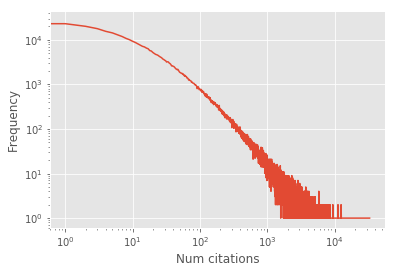

In [109]:
plt.loglog(citation_distribution.index, citation_distribution.values)
plt.xlabel('Num citations')
plt.ylabel('Frequency')
plt.show()

## Early Career Prod. vs Final Success (ID file)

In [110]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

In [111]:
x = credible_authors['early_career_prod']
y = credible_authors['final_citation_count']

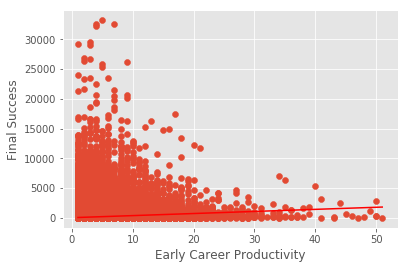

In [112]:
fig, ax = plt.subplots()
plt.scatter(x, y)
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Early Career Productivity')
plt.ylabel('Final Success')
# plt.xlim(0, 50)
# plt.ylim(0,200)
plt.show()

In [113]:
credible_authors_no_uncited = credible_authors.dropna()

In [114]:
x = credible_authors_no_uncited['early_career_prod']
y = credible_authors_no_uncited['final_citation_count']

In [115]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value)
print(slope, intercept)

0.1600052263338129
34.9687936628833 38.50205337179392


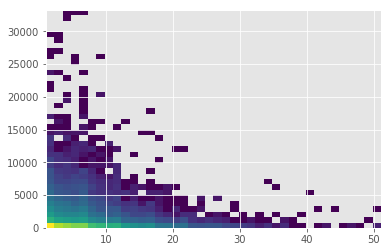

In [116]:
fig, axs = plt.subplots()
axs.hist2d(x, y, bins=40, norm=colors.LogNorm())
plt.show()

## Early Career Prod. vs Early Career Qual. (IDs file)

In [117]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

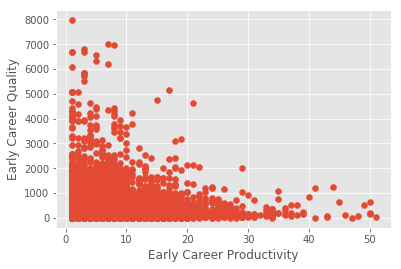

In [118]:
plt.scatter(credible_authors['early_career_prod'], credible_authors['early_career_qual'])
plt.xlabel('Early Career Productivity')
plt.ylabel('Early Career Quality')
plt.show()